In [1]:
import pandas as pd
import numpy as np
import statistics
import sklearn.metrics
import warnings
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
import os
warnings.filterwarnings("ignore")

In [2]:
def get_accuracy(annotation_df, correct_id_col='real_cellID', predicted_id_col='predicted_cellID'):
    num_correct_ann= annotation_df[annotation_df[correct_id_col]==annotation_df[predicted_id_col]].shape[0]
    acc=num_correct_ann/annotation_df.shape[0]
    return acc

In [3]:
def get_balanced_accuracy_verbose(annotation_df, correct_id_col='real_cellID', predicted_id_col='predicted_cellID'):
    ann=[]
    for cell_type in sorted(set(annotation_df[correct_id_col])):
        cell_type_sub = annotation_df[annotation_df[correct_id_col]==cell_type]
        print(cell_type)
        num_cells =cell_type_sub.shape[0]
        print("predicted cell ID")
        num_correct_ann = cell_type_sub[cell_type_sub[predicted_id_col]==cell_type].shape[0]
        #print(cell_type_sub.predicted_cellID.value_counts())
        perc=(num_correct_ann/num_cells)
        print(perc)
        ann.append(perc)
    balanced_accuracy= np.sum(ann)/len(ann)
    print("balanced accuracy:")
    print(balanced_accuracy)
    return balanced_accuracy

In [4]:
def get_balanced_accuracy(annotation_df, correct_id_col='real_cellID', predicted_id_col='predicted_cellID'):
    ann=[]
    for cell_type in sorted(set(annotation_df[correct_id_col])):
        cell_type_sub = annotation_df[annotation_df[correct_id_col]==cell_type]
        num_cells =cell_type_sub.shape[0]
        num_correct_ann = cell_type_sub[cell_type_sub[predicted_id_col]==cell_type].shape[0]
        #print(cell_type_sub.predicted_cellID.value_counts())
        perc=(num_correct_ann/num_cells)
        ann.append(perc)
    balanced_accuracy= np.sum(ann)/len(ann)
    return balanced_accuracy

In [5]:
def get_cluster_accuracy(annotation_df, cluster_id_column ='clust',correct_id_col='real_cellID', predicted_id_col='predicted_cellID'):
    correc_ann_counter=0
    annotation_df = annotation_df.groupby(cluster_id_column).filter(lambda x: len(x) > 10)
    cluster_ids =sorted(set(annotation_df[cluster_id_column]))
    for cluster_id in cluster_ids:
        cluster_sub = annotation_df[annotation_df[cluster_id_column]==cluster_id]   
        clust_real_id_counts = cluster_sub[correct_id_col].value_counts()
        # sort fist by number then by index, then get the cell type with the highest occurance. This takes care of ties
        clust_real_id = clust_real_id_counts.iloc[np.lexsort((clust_real_id_counts.index, -clust_real_id_counts.values))].index[0]
        clust_predicted_id_counts = cluster_sub[predicted_id_col].value_counts()
        # sort fist by number then by index, then get the cell type with the highest occurance. This takes care of ties
        clust_predicted_id = clust_predicted_id_counts.iloc[np.lexsort((clust_predicted_id_counts.index, -clust_predicted_id_counts.values))].index[0]
        if clust_real_id == clust_predicted_id:
            correc_ann_counter += 1
        else:
            continue
    clust_accuracy= correc_ann_counter/len(cluster_ids)
    return clust_accuracy

In [6]:
def get_cohens_kappa_score(annotation_df, correct_id_col='real_cellID', predicted_id_col='predicted_cellID'):
    cohens_kappa_score= sklearn.metrics.cohen_kappa_score(annotation_df[correct_id_col],annotation_df[predicted_id_col])
    return(cohens_kappa_score)

In [7]:
def get_F1_score(annotation_df, correct_id_col='real_cellID', predicted_id_col='predicted_cellID'):
    F1_list=[]
    for cell_type in sorted(set(annotation_df[correct_id_col])):
        # subset dataframe to the cell-type of interest 
        # then convert df labels to binary classification tasks
        cell_type_sub = annotation_df[(annotation_df[correct_id_col]==cell_type) | (annotation_df[predicted_id_col]==cell_type)]
        #cell_type_sub = cell_type_sub[[correct_id_col, predicted_id_col]]
        cell_type_sub[correct_id_col] = cell_type_sub[correct_id_col].where(cell_type_sub[correct_id_col].isin([cell_type]), 'other')
        cell_type_sub[predicted_id_col] = cell_type_sub[predicted_id_col].where(cell_type_sub[predicted_id_col].isin([cell_type]), 'other')
        F1_cell_type = sklearn.metrics.f1_score(cell_type_sub[correct_id_col], cell_type_sub[predicted_id_col], pos_label = cell_type)
        F1_list.append(F1_cell_type)
    return(F1_list)

In [8]:
def get_macroF1_score(annotation_df, correct_id_col='real_cellID', predicted_id_col='predicted_cellID', label_list=None):
    if label_list ==None:
        label_list  = annotation_df[correct_id_col].value_counts().index   
    macroF1_score = sklearn.metrics.f1_score(annotation_df[correct_id_col], annotation_df[predicted_id_col],average='macro', labels=label_list)
    return(macroF1_score)


In [9]:
def get_medianF1_score(annotation_df, correct_id_col='real_cellID', predicted_id_col='predicted_cellID'):
    F1_scores = get_F1_score(annotation_df, correct_id_col=correct_id_col, predicted_id_col=predicted_id_col)
    medianF1_score = statistics.median(F1_scores)
    return(medianF1_score)

In [10]:
def get_precision_score(annotation_df, correct_id_col='real_cellID', predicted_id_col='predicted_cellID'):
    precision_list=[]
    for cell_type in sorted(set(annotation_df[correct_id_col])):
        # subset dataframe to the cell-type of interest
        cell_type_sub = annotation_df[(annotation_df[correct_id_col]==cell_type) | (annotation_df[predicted_id_col]==cell_type)]
        cell_type_sub[correct_id_col] = cell_type_sub[correct_id_col].where(cell_type_sub[correct_id_col].isin([cell_type]), 'other')
        cell_type_sub[predicted_id_col] = cell_type_sub[predicted_id_col].where(cell_type_sub[predicted_id_col].isin([cell_type]), 'other')
        precision_cell_type = sklearn.metrics.precision_score(cell_type_sub[correct_id_col], cell_type_sub[predicted_id_col], pos_label = cell_type)
        precision_list.append(precision_cell_type)
    return(precision_list)

In [11]:
def get_medianPrecision_score(annotation_df, correct_id_col='real_cellID', predicted_id_col='predicted_cellID'):
    precision_scores = get_precision_score(annotation_df, correct_id_col=correct_id_col, predicted_id_col=predicted_id_col)
    medianPrecision_score = statistics.median(precision_scores)
    return(medianPrecision_score)

In [12]:
def get_recall_score(annotation_df, correct_id_col='real_cellID', predicted_id_col='predicted_cellID'):
    recall_list=[]
    for cell_type in sorted(set(annotation_df[correct_id_col])):
        # subset dataframe to the cell-type of interest
        cell_type_sub = annotation_df[(annotation_df[correct_id_col]==cell_type) | (annotation_df[predicted_id_col]==cell_type)]
        cell_type_sub[correct_id_col] = cell_type_sub[correct_id_col].where(cell_type_sub[correct_id_col].isin([cell_type]), 'other')
        cell_type_sub[predicted_id_col] = cell_type_sub[predicted_id_col].where(cell_type_sub[predicted_id_col].isin([cell_type]), 'other')
        recall_cell_type = sklearn.metrics.recall_score(cell_type_sub[correct_id_col], cell_type_sub[predicted_id_col], pos_label = cell_type)
        recall_list.append(recall_cell_type)
    return(recall_list)

In [13]:
def get_medianRecall_score(annotation_df, correct_id_col='real_cellID', predicted_id_col='predicted_cellID'):
    recall_scores = get_recall_score(annotation_df, correct_id_col=correct_id_col, predicted_id_col=predicted_id_col)
    medianPrecision_score = statistics.median(recall_scores)
    return(medianPrecision_score)

In [14]:
def get_adjusted_rand_score(annotation_df, correct_id_col='real_cellID', predicted_id_col='predicted_cellID'):
    adjusted_rand_score= sklearn.metrics.adjusted_rand_score(annotation_df[correct_id_col],annotation_df[predicted_id_col])
    return(adjusted_rand_score)

In [15]:
def get_mathews_corr_coef_score(annotation_df, correct_id_col='real_cellID', predicted_id_col='predicted_cellID'):
    matthews_corrcoef_score= sklearn.metrics.matthews_corrcoef(annotation_df[correct_id_col],annotation_df[predicted_id_col])
    return(matthews_corrcoef_score)

In [16]:
def get_common_cells(*dataframes):
    df_cell_list = [v.index for v in dataframes]
    common_cells= list(set.intersection(*map(set,df_cell_list)))
    return(common_cells)

In [17]:
def get_combined_annotations_df_for_common_cells(*frames, common_cells, cell_ID_column = "cell_IDs"):
    if not frames:
        return None
    if len(frames) == 1:
        return frames[0]
    out = frames[0]
    out = out.loc[common_cells,]
    for df in frames[1:]:
        out = out.merge(df.loc[common_cells,], on=cell_ID_column)
    return out

In [18]:
def plot_performance_metrics(df , colors=None, labels = None, y_min = 0.0, frame_color = 'gray', frame_width = 0.5, x_label_rotation = 45, tick_size = 14,legend_fontsize = 12,
                            legend_labels = None, legend_loc = 'upper center', legend_bbox_to_anchor=(0.5, -0.2), legend_ncol=4, save=False, save_path=None):

    # Default values
    default_colors = ['#5E0B8A', '#00A7E1', '#BDDA57', '#FF8C00']
    default_labels = ['accuracy', 'balanced \naccuracy','cluster \naccuracy', 'macro \nF1', 'median \nF1',
                      'median \nprecision', 'median \nrecall','MCC', 'ARI', "Cohen's \nkappa"]
    default_legend_labels =['scATAcat', 'Seurat label transfer', 'Cellcano', 'EpiAnno']

    # Use default if None is passed
    colors = default_colors if colors is None else colors
    labels = default_labels if labels is None else labels
    legend_labels = default_legend_labels if legend_labels is None else legend_labels
  
    df.columns = labels
    df.index = legend_labels
    
    matplotlib.rcParams['pdf.fonttype'] = 42
    matplotlib.rcParams['ps.fonttype'] = 42

    n_bins = 100  # Increase this number for a smoother gradient
    cmap = LinearSegmentedColormap.from_list('custom_cmap', colors, N=n_bins)
    ax = df.T.plot(kind='bar', figsize=(15, 10), legend=True, fontsize=12, colormap=cmap)
    ax.set_ylim(ymin=y_min)
    # Change plot frame to gray and adjust linewidth
    spine_color = 'gray'
    linewidth = frame_width # Adjust the linewidth as needed
    for spine in ax.spines.values():
        spine.set_color(spine_color)
        spine.set_linewidth(linewidth)
    ax.legend(legend_labels,fontsize=legend_fontsize, loc=legend_loc, bbox_to_anchor=legend_bbox_to_anchor,
          fancybox=False, shadow=False, ncol=legend_ncol, frameon=False)
    plt.xticks(rotation=x_label_rotation)
    plt.tick_params(axis='both', which='major', labelsize=tick_size)

    if save == False:
        plt.show()
    else:
        if save_path == None:
            print("specify the save_path directory")
        else:
            plt.savefig(save_path, bbox_inches='tight', transparent=True)

### seurat annotations

In [19]:
seurat_integration_annotations = pd.read_csv("../../../../scATAcat_notebooks_for_paper/paper_github_repo/results/Fig4_SFig2-10X_PBMC_scmultiome/Fig4_SFig2-apply_seurat_label_transfer/10XPBMC_seurat_label_transfer_annotations.csv")
seurat_integration_annotations.columns = ["cell_IDs", "label_transfer_annotations","ground_truth_annotations"]
seurat_integration_annotations.index = seurat_integration_annotations.cell_IDs
seurat_integration_annotations.index.name = None
seurat_integration_annotations

,cell_IDs,label_transfer_annotations,ground_truth_annotations
AAACAGCCAAGGAATC-1,AAACAGCCAAGGAATC-1,CD4 T,CD4 T
AAACAGCCAATCCCTT-1,AAACAGCCAATCCCTT-1,CD8 T,CD4 T
AAACAGCCAATGCGCT-1,AAACAGCCAATGCGCT-1,CD8 T,CD4 T
AAACAGCCACCAACCG-1,AAACAGCCACCAACCG-1,Mono,CD8 T
AAACAGCCAGGATAAC-1,AAACAGCCAGGATAAC-1,CD4 T,CD4 T
...,...,...,...
TTTGTTGGTGACATGC-1,TTTGTTGGTGACATGC-1,CD8 T,CD8 T
TTTGTTGGTGTTAAAC-1,TTTGTTGGTGTTAAAC-1,CD8 T,CD8 T
TTTGTTGGTTAGGATT-1,TTTGTTGGTTAGGATT-1,NK,NK
TTTGTTGGTTGGTTAG-1,TTTGTTGGTTGGTTAG-1,CD4 T,CD4 T


In [20]:
seurat_integration_annotations.label_transfer_annotations.value_counts()

label_transfer_annotations
Mono       3718
CD4 T      2841
CD8 T      2024
B           869
NK          568
DC          203
other T     131
other        58
Name: count, dtype: int64

### scATAcat annotations

In [21]:
scATAcat_annotations = pd.read_csv("../../../../scATAcat_notebooks_for_paper/paper_github_repo/results/Fig4_SFig2-10X_PBMC_scmultiome/Fig4_SFig2-apply_scATAcat/outputs/scATAcat_annotations.csv", index_col=0)
scATAcat_annotations.index.name = None
scATAcat_annotations.columns = ['leiden_1', 'scATAcat_annotation','cell_IDs']
scATAcat_annotations

,leiden_1,scATAcat_annotation,cell_IDs
AAACAGCCAATCCCTT-1,4,CD4Tcell,AAACAGCCAATCCCTT-1
AAACAGCCAATGCGCT-1,2,CD4Tcell,AAACAGCCAATGCGCT-1
AAACAGCCACCAACCG-1,1,CD4Tcell,AAACAGCCACCAACCG-1
AAACAGCCAGGATAAC-1,2,CD4Tcell,AAACAGCCAGGATAAC-1
AAACAGCCAGTTTACG-1,4,CD4Tcell,AAACAGCCAGTTTACG-1
...,...,...,...
TTTGTTGGTGACATGC-1,1,CD4Tcell,TTTGTTGGTGACATGC-1
TTTGTTGGTGTTAAAC-1,1,CD4Tcell,TTTGTTGGTGTTAAAC-1
TTTGTTGGTTAGGATT-1,9,NKcell,TTTGTTGGTTAGGATT-1
TTTGTTGGTTGGTTAG-1,6,CD4Tcell,TTTGTTGGTTGGTTAG-1


In [22]:
renaming_dict={'CD4Tcell':'CD4 T', 
            'CD8Tcell':'CD8 T',
            'pDC': 'DC',
            'NKcell' : 'NK',
            'Bcell':'B'}

scATAcat_annotations = scATAcat_annotations.replace({"scATAcat_annotation": renaming_dict})
scATAcat_annotations.head()

,leiden_1,scATAcat_annotation,cell_IDs
AAACAGCCAATCCCTT-1,4,CD4 T,AAACAGCCAATCCCTT-1
AAACAGCCAATGCGCT-1,2,CD4 T,AAACAGCCAATGCGCT-1
AAACAGCCACCAACCG-1,1,CD4 T,AAACAGCCACCAACCG-1
AAACAGCCAGGATAAC-1,2,CD4 T,AAACAGCCAGGATAAC-1
AAACAGCCAGTTTACG-1,4,CD4 T,AAACAGCCAGTTTACG-1


### Cellcano annotations

In [23]:
Cellcano_annotations = pd.read_csv("../../../results/Fig4_SFig2-10X_PBMC_scmultiome/Fig4-apply_Cellcano/output_PBMC_10x_scmultiome/predict_PBMC_10x_scmultiomecelltypes.csv")

In [24]:
Cellcano_annotations.head()

,Unnamed: 0,pred_celltype,firstround_pred_celltype,entropy
0,pbmc_granulocyte_sorted_10k_atac#TGAGCAAAGGCCT...,Basofil,Basofil,0.901396
1,pbmc_granulocyte_sorted_10k_atac#AACCGCTCATATA...,cDC,Mono1,1.227917
2,pbmc_granulocyte_sorted_10k_atac#GGAGTCTGTGAGC...,Mat-NK1,Mat-NK1,1.407144
3,pbmc_granulocyte_sorted_10k_atac#TAGCTAGGTTTGG...,Basofil,Mono2,1.424103
4,pbmc_granulocyte_sorted_10k_atac#TTGGAGGCAGGCT...,Mono1,Mono1,0.493601


In [25]:
Cellcano_annotations[['prefix', 'cell_IDs']] = Cellcano_annotations.iloc[:,0].str.split("#", n=1, expand=True)
Cellcano_annotations = Cellcano_annotations[["cell_IDs", "pred_celltype"]]
Cellcano_annotations.columns = ["cell_IDs", "Cellcano_annotations"]
Cellcano_annotations.index =Cellcano_annotations["cell_IDs"]
Cellcano_annotations.index.name = None
Cellcano_annotations.head()

,cell_IDs,Cellcano_annotations
TGAGCAAAGGCCTGGT-1,TGAGCAAAGGCCTGGT-1,Basofil
AACCGCTCATATAACC-1,AACCGCTCATATAACC-1,cDC
GGAGTCTGTGAGCAAG-1,GGAGTCTGTGAGCAAG-1,Mat-NK1
TAGCTAGGTTTGGGTA-1,TAGCTAGGTTTGGGTA-1,Basofil
TTGGAGGCAGGCTTCG-1,TTGGAGGCAGGCTTCG-1,Mono1


In [26]:
Cellcano_annotations.Cellcano_annotations.value_counts()

Cellcano_annotations
Mono2       3604
N-Treg      1728
M-CD4T      1571
N-CD8T1     1514
EM-CDT8      854
Memory-B     517
Mat-NK1      493
Naive-B      362
Basofil      296
Mono1        197
cDC          161
pDC          131
GDelta-T     128
Plasma-B      15
CM-CD8T        7
N-CD4T1        3
N-CD8T3        1
Name: count, dtype: int64

In [27]:
Cellcano_annotations_ = ['HSC/MPP','MEP','CMP/BMP','LMPP','CLP','Pro-B','Pre-B','GMP','MDP','pDC','cDC','Mono1','Mono2','Naive-B','Memory-B','Plasma-B','Basofil','Imm-NK','Mat-NK1','Mat-NK2','N-CD4T1','N-CD4T2','N-Treg','M-CD4T','Treg','N-CD8T1','N-CD8T2','N-CD8T3','CM-CD8T','EM-CDT8','GDelta-T']
Cellcano_annotations_simplified  =['other','other','other','other','other','other','other','other','other','DC','DC','Mono','Mono','B','B','B','other','NK','NK','NK','CD4 T','CD4 T','other T','CD4 T','other T','CD8 T','CD8 T','CD8 T','CD8 T','CD8 T','other T']
Cellcano_annotations_simplified_dict = dict(zip(Cellcano_annotations_, Cellcano_annotations_simplified))

print(Cellcano_annotations_simplified_dict)

{'HSC/MPP': 'other', 'MEP': 'other', 'CMP/BMP': 'other', 'LMPP': 'other', 'CLP': 'other', 'Pro-B': 'other', 'Pre-B': 'other', 'GMP': 'other', 'MDP': 'other', 'pDC': 'DC', 'cDC': 'DC', 'Mono1': 'Mono', 'Mono2': 'Mono', 'Naive-B': 'B', 'Memory-B': 'B', 'Plasma-B': 'B', 'Basofil': 'other', 'Imm-NK': 'NK', 'Mat-NK1': 'NK', 'Mat-NK2': 'NK', 'N-CD4T1': 'CD4 T', 'N-CD4T2': 'CD4 T', 'N-Treg': 'other T', 'M-CD4T': 'CD4 T', 'Treg': 'other T', 'N-CD8T1': 'CD8 T', 'N-CD8T2': 'CD8 T', 'N-CD8T3': 'CD8 T', 'CM-CD8T': 'CD8 T', 'EM-CDT8': 'CD8 T', 'GDelta-T': 'other T'}


In [28]:

Cellcano_annotations= Cellcano_annotations.assign(Cellcano_annotations_simplified=list(Cellcano_annotations['Cellcano_annotations'].map(Cellcano_annotations_simplified_dict)))
Cellcano_annotations.head()

,cell_IDs,Cellcano_annotations,Cellcano_annotations_simplified
TGAGCAAAGGCCTGGT-1,TGAGCAAAGGCCTGGT-1,Basofil,other
AACCGCTCATATAACC-1,AACCGCTCATATAACC-1,cDC,DC
GGAGTCTGTGAGCAAG-1,GGAGTCTGTGAGCAAG-1,Mat-NK1,NK
TAGCTAGGTTTGGGTA-1,TAGCTAGGTTTGGGTA-1,Basofil,other
TTGGAGGCAGGCTTCG-1,TTGGAGGCAGGCTTCG-1,Mono1,Mono


### EpiAnno annotations

In [29]:
EpiAnno_annotations = pd.read_csv("../../../results/Fig4_SFig2-10X_PBMC_scmultiome/Fig4-apply_EpiAnno/SatpathyPBMC_with_10XPBMC_via_peaks/predicted_labels.csv", index_col=0)
EpiAnno_annotations.columns = ["cell_IDs", "EpiAnno_annotations"]
EpiAnno_annotations.index =EpiAnno_annotations["cell_IDs"]
EpiAnno_annotations.index.name = None


In [30]:
EpiAnno_annotations.head()

,cell_IDs,EpiAnno_annotations
TGAGCAAAGGCCTGGT-1,TGAGCAAAGGCCTGGT-1,Mono2
AACCGCTCATATAACC-1,AACCGCTCATATAACC-1,HSC/MPP
GGAGTCTGTGAGCAAG-1,GGAGTCTGTGAGCAAG-1,CM-CD8T
TAGCTAGGTTTGGGTA-1,TAGCTAGGTTTGGGTA-1,Mono1
TTGGAGGCAGGCTTCG-1,TTGGAGGCAGGCTTCG-1,Mono1


In [31]:
EpiAnno_annotations_ = ['HSC/MPP','MEP','CMP/BMP','LMPP','CLP','Pro-B','Pre-B','GMP','MDP','pDC','cDC','Mono1','Mono2','Naive-B','Memory-B','Plasma-B','Basofil','Imm-NK','Mat-NK1','Mat-NK2','N-CD4T1','N-CD4T2','N-Treg','M-CD4T','Treg','N-CD8T1','N-CD8T2','N-CD8T3','CM-CD8T','EM-CDT8','GDelta-T']
EpiAnno_annotations_simplified  =['other','other','other','other','other','other','other','other','other','DC','DC','Mono','Mono','B','B','B','other','NK','NK','NK','CD4 T','CD4 T','other T','CD4 T','other T','CD8 T','CD8 T','CD8 T','CD8 T','CD8 T','other T']
EpiAnno_annotations_simplified_dict = dict(zip(EpiAnno_annotations_, EpiAnno_annotations_simplified))

print(EpiAnno_annotations_simplified_dict)

{'HSC/MPP': 'other', 'MEP': 'other', 'CMP/BMP': 'other', 'LMPP': 'other', 'CLP': 'other', 'Pro-B': 'other', 'Pre-B': 'other', 'GMP': 'other', 'MDP': 'other', 'pDC': 'DC', 'cDC': 'DC', 'Mono1': 'Mono', 'Mono2': 'Mono', 'Naive-B': 'B', 'Memory-B': 'B', 'Plasma-B': 'B', 'Basofil': 'other', 'Imm-NK': 'NK', 'Mat-NK1': 'NK', 'Mat-NK2': 'NK', 'N-CD4T1': 'CD4 T', 'N-CD4T2': 'CD4 T', 'N-Treg': 'other T', 'M-CD4T': 'CD4 T', 'Treg': 'other T', 'N-CD8T1': 'CD8 T', 'N-CD8T2': 'CD8 T', 'N-CD8T3': 'CD8 T', 'CM-CD8T': 'CD8 T', 'EM-CDT8': 'CD8 T', 'GDelta-T': 'other T'}


In [32]:

EpiAnno_annotations= EpiAnno_annotations.assign(EpiAnno_annotations_simplified=list(EpiAnno_annotations['EpiAnno_annotations'].map(EpiAnno_annotations_simplified_dict)))
EpiAnno_annotations.head()

,cell_IDs,EpiAnno_annotations,EpiAnno_annotations_simplified
TGAGCAAAGGCCTGGT-1,TGAGCAAAGGCCTGGT-1,Mono2,Mono
AACCGCTCATATAACC-1,AACCGCTCATATAACC-1,HSC/MPP,other
GGAGTCTGTGAGCAAG-1,GGAGTCTGTGAGCAAG-1,CM-CD8T,CD8 T
TAGCTAGGTTTGGGTA-1,TAGCTAGGTTTGGGTA-1,Mono1,Mono
TTGGAGGCAGGCTTCG-1,TTGGAGGCAGGCTTCG-1,Mono1,Mono


In [33]:
EpiAnno_annotations.EpiAnno_annotations.value_counts()

EpiAnno_annotations
Mono2       3534
N-CD8T1     2510
M-CD4T      1215
Mat-NK2      578
CM-CD8T      573
Mat-NK1      545
Memory-B     421
Naive-B      375
Mono1        267
EM-CDT8      236
N-Treg       175
N-CD4T1      158
GDelta-T     145
Basofil      137
cDC          121
N-CD8T3      116
pDC          109
Treg          97
Plasma-B      84
MDP           68
LMPP          41
MEP           37
HSC/MPP       36
CMP/BMP        3
N-CD4T2        1
Name: count, dtype: int64

## combine the annotations for the common cells:


In [34]:
common_cells = get_common_cells(scATAcat_annotations, seurat_integration_annotations,Cellcano_annotations, EpiAnno_annotations)

In [35]:
pd.DataFrame(common_cells).to_csv("../../../results/Fig4_SFig2-10X_PBMC_scmultiome/compare_annotation_performances/commonCells.csv",index=False)


In [36]:
all_methods_for_commonCells = get_combined_annotations_df_for_common_cells(scATAcat_annotations, seurat_integration_annotations,Cellcano_annotations, EpiAnno_annotations, common_cells=common_cells, cell_ID_column = "cell_IDs")

In [37]:
all_methods_for_commonCells

,leiden_1,scATAcat_annotation,cell_IDs,label_transfer_annotations,ground_truth_annotations,Cellcano_annotations,Cellcano_annotations_simplified,EpiAnno_annotations,EpiAnno_annotations_simplified
0,1,CD4 T,ATCAAGACAATGCCCG-1,CD8 T,CD8 T,N-CD8T1,CD8 T,N-CD8T3,CD8 T
1,1,CD4 T,ACGTACCCATGAAATG-1,CD8 T,CD8 T,N-CD8T1,CD8 T,N-CD8T1,CD8 T
2,4,CD4 T,GGAGTCTGTTGTAAAC-1,CD4 T,CD4 T,M-CD4T,CD4 T,CM-CD8T,CD8 T
3,2,CD4 T,GCTTGACCACCTGCCT-1,CD4 T,CD4 T,M-CD4T,CD4 T,N-CD8T1,CD8 T
4,5,CD8 T,AGTAAGTAGGATGATG-1,CD8 T,CD8 T,EM-CDT8,CD8 T,CM-CD8T,CD8 T
...,...,...,...,...,...,...,...,...,...
9661,6,CD4 T,ACACCTTGTGACATGC-1,CD4 T,CD4 T,M-CD4T,CD4 T,M-CD4T,CD4 T
9662,2,CD4 T,ATTGAAGCACTTACAG-1,CD4 T,CD4 T,N-Treg,other T,N-CD8T1,CD8 T
9663,0,Mono,TGTAATGTCCCGTTAC-1,Mono,Mono,Mono2,Mono,Mono2,Mono
9664,2,CD4 T,TCTCAATTCAATCTAG-1,CD4 T,CD4 T,N-Treg,other T,N-CD8T1,CD8 T


## subset the ground truth to common annotations


In [38]:
common_annotations = list(set(all_methods_for_commonCells.scATAcat_annotation)
                          &set(all_methods_for_commonCells.ground_truth_annotations)
                          &set(all_methods_for_commonCells.label_transfer_annotations)
                          &set(all_methods_for_commonCells.Cellcano_annotations_simplified)
                          &set(all_methods_for_commonCells.EpiAnno_annotations_simplified))
common_annotations

['NK', 'CD8 T', 'CD4 T', 'DC', 'Mono', 'B']

In [39]:
all_methods_for_commonCells_commonAnnotations = all_methods_for_commonCells[all_methods_for_commonCells.ground_truth_annotations.isin(common_annotations)]

In [40]:
all_methods_for_commonCells_commonAnnotations

,leiden_1,scATAcat_annotation,cell_IDs,label_transfer_annotations,ground_truth_annotations,Cellcano_annotations,Cellcano_annotations_simplified,EpiAnno_annotations,EpiAnno_annotations_simplified
0,1,CD4 T,ATCAAGACAATGCCCG-1,CD8 T,CD8 T,N-CD8T1,CD8 T,N-CD8T3,CD8 T
1,1,CD4 T,ACGTACCCATGAAATG-1,CD8 T,CD8 T,N-CD8T1,CD8 T,N-CD8T1,CD8 T
2,4,CD4 T,GGAGTCTGTTGTAAAC-1,CD4 T,CD4 T,M-CD4T,CD4 T,CM-CD8T,CD8 T
3,2,CD4 T,GCTTGACCACCTGCCT-1,CD4 T,CD4 T,M-CD4T,CD4 T,N-CD8T1,CD8 T
4,5,CD8 T,AGTAAGTAGGATGATG-1,CD8 T,CD8 T,EM-CDT8,CD8 T,CM-CD8T,CD8 T
...,...,...,...,...,...,...,...,...,...
9661,6,CD4 T,ACACCTTGTGACATGC-1,CD4 T,CD4 T,M-CD4T,CD4 T,M-CD4T,CD4 T
9662,2,CD4 T,ATTGAAGCACTTACAG-1,CD4 T,CD4 T,N-Treg,other T,N-CD8T1,CD8 T
9663,0,Mono,TGTAATGTCCCGTTAC-1,Mono,Mono,Mono2,Mono,Mono2,Mono
9664,2,CD4 T,TCTCAATTCAATCTAG-1,CD4 T,CD4 T,N-Treg,other T,N-CD8T1,CD8 T


In [41]:
scores_df = pd.DataFrame(index=["scATAcat", "Seurat_label_transfer", "Cellcano", "EpiAnno"])


In [42]:
all_methods_for_commonCells_commonAnnotations.columns

Index(['leiden_1', 'scATAcat_annotation', 'cell_IDs',
       'label_transfer_annotations', 'ground_truth_annotations',
       'Cellcano_annotations', 'Cellcano_annotations_simplified',
       'EpiAnno_annotations', 'EpiAnno_annotations_simplified'],
      dtype='object')

## scores only for common cells and common annotations

In [67]:
scores_df = pd.DataFrame(index=["scATAcat", "Seurat_label_transfer", "Cellcano", "EpiAnno"],
                        columns=["accuracy","balanced_accuracy","cluster_accuracy","macroF1_score","medianF1_score","medianPrecision_score","medianRecall_score","mathews_corr_coef_score","adjusted_rand_score","cohens_kappa_score"])

common_cells = get_common_cells(scATAcat_annotations, seurat_integration_annotations,Cellcano_annotations, EpiAnno_annotations)
all_methods_for_commonCells = get_combined_annotations_df_for_common_cells(scATAcat_annotations, seurat_integration_annotations,Cellcano_annotations, EpiAnno_annotations, common_cells=common_cells, cell_ID_column = "cell_IDs")
common_annotations = list(set(all_methods_for_commonCells.scATAcat_annotation)
                          &set(all_methods_for_commonCells.ground_truth_annotations)
                          &set(all_methods_for_commonCells.label_transfer_annotations)
                          &set(all_methods_for_commonCells.Cellcano_annotations_simplified)
                          &set(all_methods_for_commonCells.EpiAnno_annotations_simplified))
all_methods_for_commonCells_commonAnnotations = all_methods_for_commonCells[all_methods_for_commonCells.ground_truth_annotations.isin(common_annotations)]
annotation_df = all_methods_for_commonCells_commonAnnotations
correct_id_col = 'ground_truth_annotations'
cluster_id_column ='leiden_1'
for method in scores_df.index:
    if method == "scATAcat":
        predicted_id_col = "scATAcat_annotation"
        scores_df.loc["scATAcat", "accuracy"] = get_accuracy(annotation_df = annotation_df,correct_id_col=correct_id_col,predicted_id_col=predicted_id_col)
        scores_df.loc["scATAcat", "balanced_accuracy"] = get_balanced_accuracy(annotation_df = annotation_df,correct_id_col=correct_id_col,predicted_id_col=predicted_id_col)
        scores_df.loc["scATAcat", "cluster_accuracy"] =  get_cluster_accuracy(annotation_df = annotation_df, cluster_id_column =cluster_id_column,correct_id_col=correct_id_col, predicted_id_col=predicted_id_col)
        scores_df.loc["scATAcat", "macroF1_score"] = get_macroF1_score(annotation_df = annotation_df, correct_id_col=correct_id_col, predicted_id_col=predicted_id_col, label_list=None)
        scores_df.loc["scATAcat", "medianF1_score"] = get_medianF1_score(annotation_df = annotation_df,correct_id_col=correct_id_col,predicted_id_col=predicted_id_col)
        scores_df.loc["scATAcat", "medianPrecision_score"] = get_medianPrecision_score(annotation_df = annotation_df,correct_id_col=correct_id_col,predicted_id_col=predicted_id_col)
        scores_df.loc["scATAcat", "medianRecall_score"] =  get_medianRecall_score(annotation_df = annotation_df,correct_id_col=correct_id_col,predicted_id_col=predicted_id_col)
        scores_df.loc["scATAcat", "mathews_corr_coef_score"] = get_mathews_corr_coef_score(annotation_df = annotation_df,correct_id_col=correct_id_col,predicted_id_col=predicted_id_col)
        scores_df.loc["scATAcat", "adjusted_rand_score"] = get_adjusted_rand_score(annotation_df = annotation_df,correct_id_col=correct_id_col,predicted_id_col=predicted_id_col)
        scores_df.loc["scATAcat", "cohens_kappa_score"] =  get_cohens_kappa_score(annotation_df = annotation_df,correct_id_col=correct_id_col,predicted_id_col=predicted_id_col)
    if method == "Seurat_label_transfer":
        predicted_id_col = "label_transfer_annotations"
        scores_df.loc["Seurat_label_transfer", "accuracy"] = get_accuracy(annotation_df = annotation_df,correct_id_col=correct_id_col,predicted_id_col=predicted_id_col)
        scores_df.loc["Seurat_label_transfer", "balanced_accuracy"] = get_balanced_accuracy(annotation_df = annotation_df,correct_id_col=correct_id_col,predicted_id_col=predicted_id_col)
        scores_df.loc["Seurat_label_transfer", "cluster_accuracy"] =  get_cluster_accuracy(annotation_df = annotation_df, cluster_id_column =cluster_id_column,correct_id_col=correct_id_col, predicted_id_col=predicted_id_col)
        scores_df.loc["Seurat_label_transfer", "macroF1_score"] = get_macroF1_score(annotation_df = annotation_df, correct_id_col=correct_id_col, predicted_id_col=predicted_id_col, label_list=None)
        scores_df.loc["Seurat_label_transfer", "medianF1_score"] = get_medianF1_score(annotation_df = annotation_df,correct_id_col=correct_id_col,predicted_id_col=predicted_id_col)
        scores_df.loc["Seurat_label_transfer", "medianPrecision_score"] = get_medianPrecision_score(annotation_df = annotation_df,correct_id_col=correct_id_col,predicted_id_col=predicted_id_col)
        scores_df.loc["Seurat_label_transfer", "medianRecall_score"] =  get_medianRecall_score(annotation_df = annotation_df,correct_id_col=correct_id_col,predicted_id_col=predicted_id_col)
        scores_df.loc["Seurat_label_transfer", "mathews_corr_coef_score"] = get_mathews_corr_coef_score(annotation_df = annotation_df,correct_id_col=correct_id_col,predicted_id_col=predicted_id_col)
        scores_df.loc["Seurat_label_transfer", "adjusted_rand_score"] = get_adjusted_rand_score(annotation_df = annotation_df,correct_id_col=correct_id_col,predicted_id_col=predicted_id_col)
        scores_df.loc["Seurat_label_transfer", "cohens_kappa_score"] =  get_cohens_kappa_score(annotation_df = annotation_df,correct_id_col=correct_id_col,predicted_id_col=predicted_id_col)
    if method == "Cellcano":
        predicted_id_col = "Cellcano_annotations_simplified"
        scores_df.loc["Cellcano", "accuracy"] = get_accuracy(annotation_df = annotation_df,correct_id_col=correct_id_col,predicted_id_col=predicted_id_col)
        scores_df.loc["Cellcano", "balanced_accuracy"] = get_balanced_accuracy(annotation_df = annotation_df,correct_id_col=correct_id_col,predicted_id_col=predicted_id_col)
        scores_df.loc["Cellcano", "cluster_accuracy"] =  get_cluster_accuracy(annotation_df = annotation_df, cluster_id_column =cluster_id_column,correct_id_col=correct_id_col, predicted_id_col=predicted_id_col)
        scores_df.loc["Cellcano", "macroF1_score"] = get_macroF1_score(annotation_df = annotation_df, correct_id_col=correct_id_col, predicted_id_col=predicted_id_col, label_list=None)
        scores_df.loc["Cellcano", "medianF1_score"] = get_medianF1_score(annotation_df = annotation_df,correct_id_col=correct_id_col,predicted_id_col=predicted_id_col)
        scores_df.loc["Cellcano", "medianPrecision_score"] = get_medianPrecision_score(annotation_df = annotation_df,correct_id_col=correct_id_col,predicted_id_col=predicted_id_col)
        scores_df.loc["Cellcano", "medianRecall_score"] =  get_medianRecall_score(annotation_df = annotation_df,correct_id_col=correct_id_col,predicted_id_col=predicted_id_col)
        scores_df.loc["Cellcano", "mathews_corr_coef_score"] = get_mathews_corr_coef_score(annotation_df = annotation_df,correct_id_col=correct_id_col,predicted_id_col=predicted_id_col)
        scores_df.loc["Cellcano", "adjusted_rand_score"] = get_adjusted_rand_score(annotation_df = annotation_df,correct_id_col=correct_id_col,predicted_id_col=predicted_id_col)
        scores_df.loc["Cellcano", "cohens_kappa_score"] =  get_cohens_kappa_score(annotation_df = annotation_df,correct_id_col=correct_id_col,predicted_id_col=predicted_id_col)
    if method == "EpiAnno":
        predicted_id_col = "EpiAnno_annotations_simplified"
        scores_df.loc["EpiAnno", "accuracy"] = get_accuracy(annotation_df = annotation_df,correct_id_col=correct_id_col,predicted_id_col=predicted_id_col)
        scores_df.loc["EpiAnno", "balanced_accuracy"] = get_balanced_accuracy(annotation_df = annotation_df,correct_id_col=correct_id_col,predicted_id_col=predicted_id_col)
        scores_df.loc["EpiAnno", "cluster_accuracy"] =  get_cluster_accuracy(annotation_df = annotation_df, cluster_id_column =cluster_id_column,correct_id_col=correct_id_col, predicted_id_col=predicted_id_col)
        scores_df.loc["EpiAnno", "macroF1_score"] = get_macroF1_score(annotation_df = annotation_df, correct_id_col=correct_id_col, predicted_id_col=predicted_id_col, label_list=None)
        scores_df.loc["EpiAnno", "medianF1_score"] = get_medianF1_score(annotation_df = annotation_df,correct_id_col=correct_id_col,predicted_id_col=predicted_id_col)
        scores_df.loc["EpiAnno", "medianPrecision_score"] = get_medianPrecision_score(annotation_df = annotation_df,correct_id_col=correct_id_col,predicted_id_col=predicted_id_col)
        scores_df.loc["EpiAnno", "medianRecall_score"] =  get_medianRecall_score(annotation_df = annotation_df,correct_id_col=correct_id_col,predicted_id_col=predicted_id_col)
        scores_df.loc["EpiAnno", "mathews_corr_coef_score"] = get_mathews_corr_coef_score(annotation_df = annotation_df,correct_id_col=correct_id_col,predicted_id_col=predicted_id_col)
        scores_df.loc["EpiAnno", "adjusted_rand_score"] = get_adjusted_rand_score(annotation_df = annotation_df,correct_id_col=correct_id_col,predicted_id_col=predicted_id_col)
        scores_df.loc["EpiAnno", "cohens_kappa_score"] =  get_cohens_kappa_score(annotation_df = annotation_df,correct_id_col=correct_id_col,predicted_id_col=predicted_id_col)


In [68]:
scores_df

,accuracy,balanced_accuracy,cluster_accuracy,macroF1_score,medianF1_score,medianPrecision_score,medianRecall_score,mathews_corr_coef_score,adjusted_rand_score,cohens_kappa_score
scATAcat,0.837872,0.766849,0.857143,0.796566,0.867415,0.962349,0.925195,0.793292,0.714263,0.774504
Seurat_label_transfer,0.91173,0.901721,1.0,0.907948,0.911709,0.902383,0.918704,0.881888,0.784732,0.880638
Cellcano,0.811381,0.857553,0.928571,0.890859,0.92527,0.970593,0.925547,0.787018,0.791087,0.760708
EpiAnno,0.690792,0.761912,0.785714,0.727141,0.727139,0.86752,0.841435,0.622368,0.614642,0.601283


In [45]:
figures_dir = "../../../results/Fig4_SFig2-10X_PBMC_scmultiome/compare_annotation_performances/figures/"

In [46]:
os.makedirs(figures_dir, exist_ok=True )

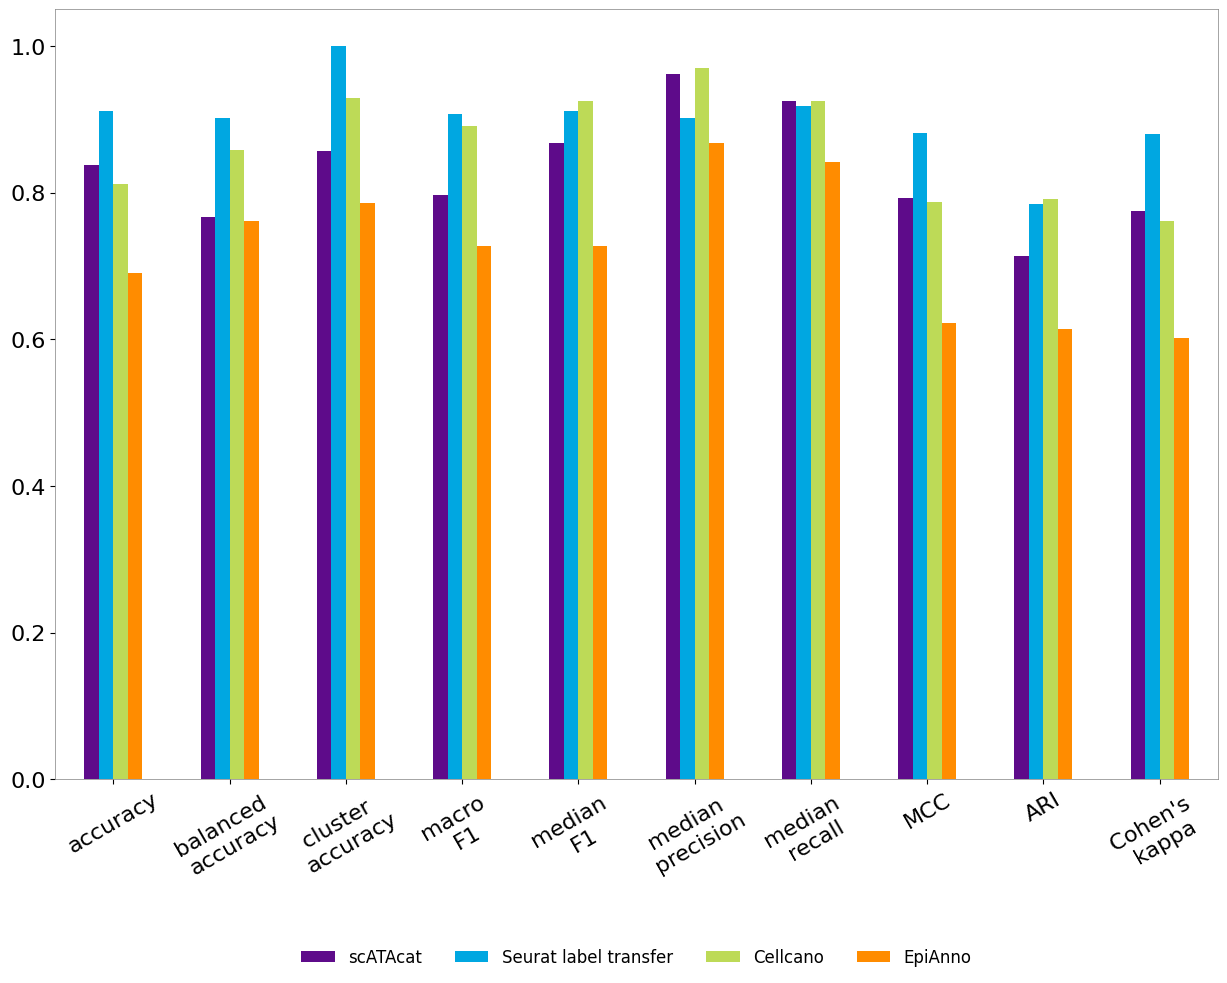

In [69]:
plot_performance_metrics(df = scores_df, save=True, tick_size=16, legend_fontsize=12, x_label_rotation = 30,
                         labels= ['accuracy', 'balanced \naccuracy','cluster \naccuracy', 'macro \nF1', 'median \nF1',
                          'median \nprecision', 'median \nrecall','MCC', 'ARI', "Cohen's \nkappa"],
                         save_path=figures_dir+ '/common_cells_common_annotations.png')

## scores for common cells & pairwise common for annotations

In [70]:
scores_df = pd.DataFrame(index=["scATAcat", "Seurat_label_transfer", "Cellcano", "EpiAnno"],
                        columns=["accuracy","balanced_accuracy","cluster_accuracy","macroF1_score","medianF1_score","medianPrecision_score","medianRecall_score","mathews_corr_coef_score","adjusted_rand_score","cohens_kappa_score"])
common_cells = get_common_cells(scATAcat_annotations, seurat_integration_annotations,Cellcano_annotations, EpiAnno_annotations)
all_methods_for_commonCells = get_combined_annotations_df_for_common_cells(scATAcat_annotations, seurat_integration_annotations,Cellcano_annotations, EpiAnno_annotations, common_cells=common_cells, cell_ID_column = "cell_IDs")
correct_id_col = 'ground_truth_annotations'
cluster_id_column ='leiden_1'
for method in scores_df.index:
    if method == "scATAcat":
        common_annotations = list(set(all_methods_for_commonCells.scATAcat_annotation))
        all_methods_for_commonCells_commonAnnotations = all_methods_for_commonCells[all_methods_for_commonCells.ground_truth_annotations.isin(common_annotations)]
        annotation_df = all_methods_for_commonCells_commonAnnotations
        print(annotation_df.shape)
        predicted_id_col = "scATAcat_annotation"
        scores_df.loc["scATAcat", "accuracy"] = get_accuracy(annotation_df = annotation_df,correct_id_col=correct_id_col,predicted_id_col=predicted_id_col)
        scores_df.loc["scATAcat", "balanced_accuracy"] = get_balanced_accuracy(annotation_df = annotation_df,correct_id_col=correct_id_col,predicted_id_col=predicted_id_col)
        scores_df.loc["scATAcat", "cluster_accuracy"] =  get_cluster_accuracy(annotation_df = annotation_df, cluster_id_column =cluster_id_column,correct_id_col=correct_id_col, predicted_id_col=predicted_id_col)
        scores_df.loc["scATAcat", "macroF1_score"] = get_macroF1_score(annotation_df = annotation_df, correct_id_col=correct_id_col, predicted_id_col=predicted_id_col, label_list=None)
        scores_df.loc["scATAcat", "medianF1_score"] = get_medianF1_score(annotation_df = annotation_df,correct_id_col=correct_id_col,predicted_id_col=predicted_id_col)
        scores_df.loc["scATAcat", "medianPrecision_score"] = get_medianPrecision_score(annotation_df = annotation_df,correct_id_col=correct_id_col,predicted_id_col=predicted_id_col)
        scores_df.loc["scATAcat", "medianRecall_score"] =  get_medianRecall_score(annotation_df = annotation_df,correct_id_col=correct_id_col,predicted_id_col=predicted_id_col)
        scores_df.loc["scATAcat", "mathews_corr_coef_score"] = get_mathews_corr_coef_score(annotation_df = annotation_df,correct_id_col=correct_id_col,predicted_id_col=predicted_id_col)
        scores_df.loc["scATAcat", "adjusted_rand_score"] = get_adjusted_rand_score(annotation_df = annotation_df,correct_id_col=correct_id_col,predicted_id_col=predicted_id_col)
        scores_df.loc["scATAcat", "cohens_kappa_score"] =  get_cohens_kappa_score(annotation_df = annotation_df,correct_id_col=correct_id_col,predicted_id_col=predicted_id_col)
    if method == "Seurat_label_transfer":
        # common_cells = get_common_cells(seurat_integration_annotations,ground_truth_annotations_)
        # all_methods_for_commonCells = get_combined_annotations_df_for_common_cells(seurat_integration_annotations,ground_truth_annotations_, common_cells=common_cells, cell_ID_column = "cell_IDs")
        common_annotations = list(set(all_methods_for_commonCells.ground_truth_annotations)
                                  &set(all_methods_for_commonCells.label_transfer_annotations))
        all_methods_for_commonCells_commonAnnotations = all_methods_for_commonCells[all_methods_for_commonCells.ground_truth_annotations.isin(common_annotations)]
        annotation_df = all_methods_for_commonCells_commonAnnotations 
        print(annotation_df.shape)
        predicted_id_col = "label_transfer_annotations"
        scores_df.loc["Seurat_label_transfer", "accuracy"] = get_accuracy(annotation_df = annotation_df,correct_id_col=correct_id_col,predicted_id_col=predicted_id_col)
        scores_df.loc["Seurat_label_transfer", "balanced_accuracy"] = get_balanced_accuracy(annotation_df = annotation_df,correct_id_col=correct_id_col,predicted_id_col=predicted_id_col)
        scores_df.loc["Seurat_label_transfer", "cluster_accuracy"] =  get_cluster_accuracy(annotation_df = annotation_df, cluster_id_column =cluster_id_column,correct_id_col=correct_id_col, predicted_id_col=predicted_id_col)
        scores_df.loc["Seurat_label_transfer", "macroF1_score"] = get_macroF1_score(annotation_df = annotation_df, correct_id_col=correct_id_col, predicted_id_col=predicted_id_col, label_list=None)
        scores_df.loc["Seurat_label_transfer", "medianF1_score"] = get_medianF1_score(annotation_df = annotation_df,correct_id_col=correct_id_col,predicted_id_col=predicted_id_col)
        scores_df.loc["Seurat_label_transfer", "medianPrecision_score"] = get_medianPrecision_score(annotation_df = annotation_df,correct_id_col=correct_id_col,predicted_id_col=predicted_id_col)
        scores_df.loc["Seurat_label_transfer", "medianRecall_score"] =  get_medianRecall_score(annotation_df = annotation_df,correct_id_col=correct_id_col,predicted_id_col=predicted_id_col)
        scores_df.loc["Seurat_label_transfer", "mathews_corr_coef_score"] = get_mathews_corr_coef_score(annotation_df = annotation_df,correct_id_col=correct_id_col,predicted_id_col=predicted_id_col)
        scores_df.loc["Seurat_label_transfer", "adjusted_rand_score"] = get_adjusted_rand_score(annotation_df = annotation_df,correct_id_col=correct_id_col,predicted_id_col=predicted_id_col)
        scores_df.loc["Seurat_label_transfer", "cohens_kappa_score"] =  get_cohens_kappa_score(annotation_df = annotation_df,correct_id_col=correct_id_col,predicted_id_col=predicted_id_col)
    if method == "Cellcano":
        # common_cells = get_common_cells(Cellcano_annotations,ground_truth_annotations_)
        # all_methods_for_commonCells = get_combined_annotations_df_for_common_cells(Cellcano_annotations,ground_truth_annotations_, common_cells=common_cells, cell_ID_column = "cell_IDs")
        common_annotations = list(set(all_methods_for_commonCells.ground_truth_annotations)
                                  &set(all_methods_for_commonCells.Cellcano_annotations_simplified))
        all_methods_for_commonCells_commonAnnotations = all_methods_for_commonCells[all_methods_for_commonCells.ground_truth_annotations.isin(common_annotations)]
        annotation_df = all_methods_for_commonCells_commonAnnotations  
        print(annotation_df.shape)
        predicted_id_col = "Cellcano_annotations_simplified"
        scores_df.loc["Cellcano", "accuracy"] = get_accuracy(annotation_df = annotation_df,correct_id_col=correct_id_col,predicted_id_col=predicted_id_col)
        scores_df.loc["Cellcano", "balanced_accuracy"] = get_balanced_accuracy(annotation_df = annotation_df,correct_id_col=correct_id_col,predicted_id_col=predicted_id_col)
        scores_df.loc["Cellcano", "cluster_accuracy"] =  get_cluster_accuracy(annotation_df = annotation_df, cluster_id_column =cluster_id_column,correct_id_col=correct_id_col, predicted_id_col=predicted_id_col)
        scores_df.loc["Cellcano", "macroF1_score"] = get_macroF1_score(annotation_df = annotation_df, correct_id_col=correct_id_col, predicted_id_col=predicted_id_col, label_list=None)
        scores_df.loc["Cellcano", "medianF1_score"] = get_medianF1_score(annotation_df = annotation_df,correct_id_col=correct_id_col,predicted_id_col=predicted_id_col)
        scores_df.loc["Cellcano", "medianPrecision_score"] = get_medianPrecision_score(annotation_df = annotation_df,correct_id_col=correct_id_col,predicted_id_col=predicted_id_col)
        scores_df.loc["Cellcano", "medianRecall_score"] =  get_medianRecall_score(annotation_df = annotation_df,correct_id_col=correct_id_col,predicted_id_col=predicted_id_col)
        scores_df.loc["Cellcano", "mathews_corr_coef_score"] = get_mathews_corr_coef_score(annotation_df = annotation_df,correct_id_col=correct_id_col,predicted_id_col=predicted_id_col)
        scores_df.loc["Cellcano", "adjusted_rand_score"] = get_adjusted_rand_score(annotation_df = annotation_df,correct_id_col=correct_id_col,predicted_id_col=predicted_id_col)
        scores_df.loc["Cellcano", "cohens_kappa_score"] =  get_cohens_kappa_score(annotation_df = annotation_df,correct_id_col=correct_id_col,predicted_id_col=predicted_id_col)
    if method == "EpiAnno":
        # common_cells = get_common_cells(EpiAnno_annotations,ground_truth_annotations_)
        # all_methods_for_commonCells = get_combined_annotations_df_for_common_cells(EpiAnno_annotations,ground_truth_annotations_, common_cells=common_cells, cell_ID_column = "cell_IDs")
        common_annotations = list(set(all_methods_for_commonCells.ground_truth_annotations)
                                  &set(all_methods_for_commonCells.EpiAnno_annotations_simplified))
        all_methods_for_commonCells_commonAnnotations = all_methods_for_commonCells[all_methods_for_commonCells.ground_truth_annotations.isin(common_annotations)]
        annotation_df = all_methods_for_commonCells_commonAnnotations
        print(annotation_df.shape)
        predicted_id_col = "EpiAnno_annotations_simplified"
        scores_df.loc["EpiAnno", "accuracy"] = get_accuracy(annotation_df = annotation_df,correct_id_col=correct_id_col,predicted_id_col=predicted_id_col)
        scores_df.loc["EpiAnno", "balanced_accuracy"] = get_balanced_accuracy(annotation_df = annotation_df,correct_id_col=correct_id_col,predicted_id_col=predicted_id_col)
        scores_df.loc["EpiAnno", "cluster_accuracy"] =  get_cluster_accuracy(annotation_df = annotation_df, cluster_id_column =cluster_id_column,correct_id_col=correct_id_col, predicted_id_col=predicted_id_col)
        scores_df.loc["EpiAnno", "macroF1_score"] = get_macroF1_score(annotation_df = annotation_df, correct_id_col=correct_id_col, predicted_id_col=predicted_id_col, label_list=None)
        scores_df.loc["EpiAnno", "medianF1_score"] = get_medianF1_score(annotation_df = annotation_df,correct_id_col=correct_id_col,predicted_id_col=predicted_id_col)
        scores_df.loc["EpiAnno", "medianPrecision_score"] = get_medianPrecision_score(annotation_df = annotation_df,correct_id_col=correct_id_col,predicted_id_col=predicted_id_col)
        scores_df.loc["EpiAnno", "medianRecall_score"] =  get_medianRecall_score(annotation_df = annotation_df,correct_id_col=correct_id_col,predicted_id_col=predicted_id_col)
        scores_df.loc["EpiAnno", "mathews_corr_coef_score"] = get_mathews_corr_coef_score(annotation_df = annotation_df,correct_id_col=correct_id_col,predicted_id_col=predicted_id_col)
        scores_df.loc["EpiAnno", "adjusted_rand_score"] = get_adjusted_rand_score(annotation_df = annotation_df,correct_id_col=correct_id_col,predicted_id_col=predicted_id_col)
        scores_df.loc["EpiAnno", "cohens_kappa_score"] =  get_cohens_kappa_score(annotation_df = annotation_df,correct_id_col=correct_id_col,predicted_id_col=predicted_id_col)


(9437, 9)
(9666, 9)
(9666, 9)
(9666, 9)


In [71]:
scores_df

,accuracy,balanced_accuracy,cluster_accuracy,macroF1_score,medianF1_score,medianPrecision_score,medianRecall_score,mathews_corr_coef_score,adjusted_rand_score,cohens_kappa_score
scATAcat,0.837872,0.766849,0.857143,0.796566,0.867415,0.962349,0.925195,0.793292,0.714263,0.774504
Seurat_label_transfer,0.902235,0.832226,1.0,0.81832,0.889794,0.900813,0.918704,0.870736,0.777912,0.869541
Cellcano,0.802193,0.706809,0.933333,0.681528,0.911811,0.966263,0.925547,0.773195,0.773188,0.750314
EpiAnno,0.676702,0.675629,0.733333,0.570601,0.694093,0.86113,0.841435,0.607127,0.606739,0.587228


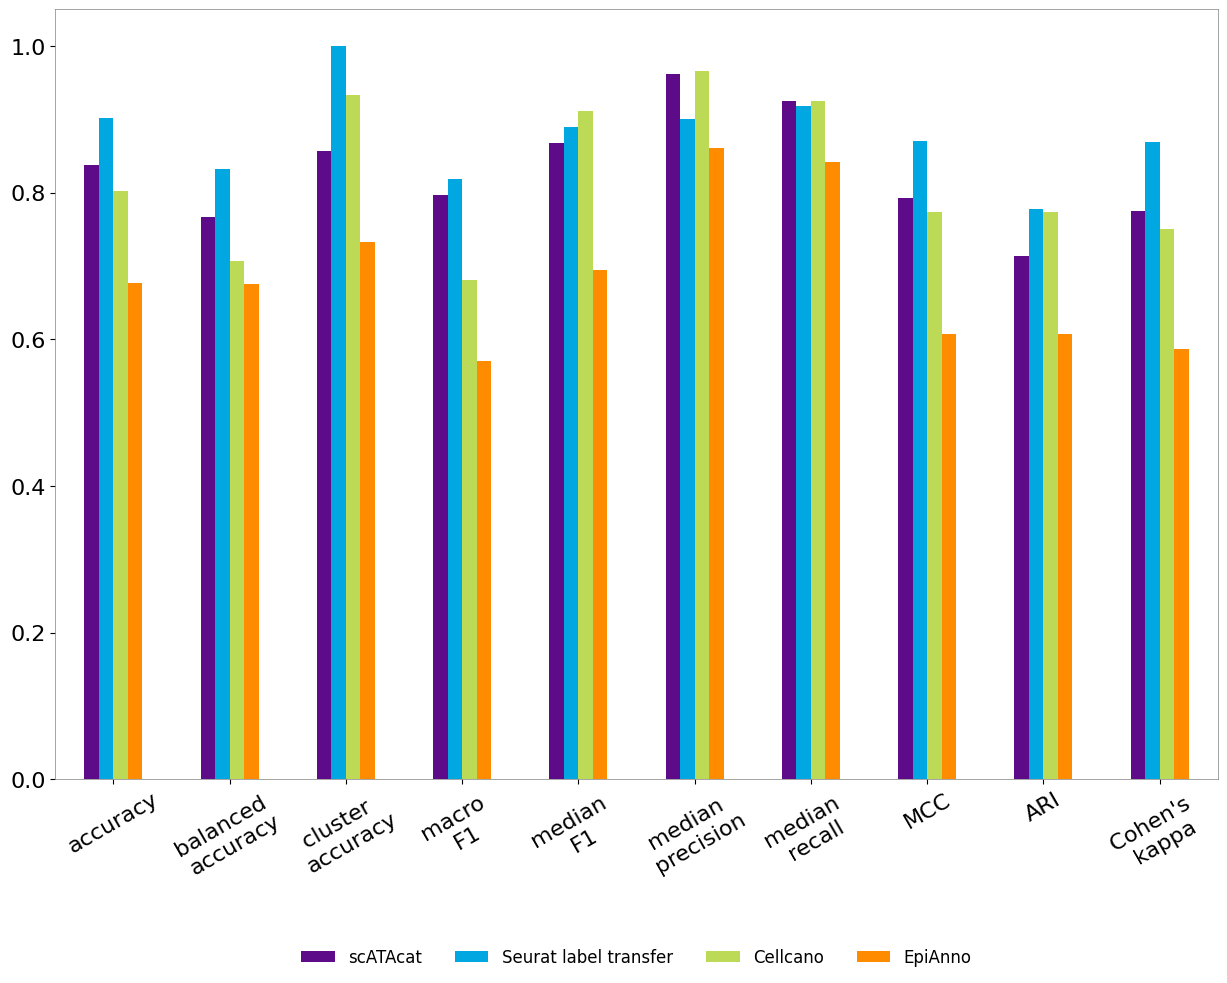

In [72]:
plot_performance_metrics(df = scores_df, save=True, tick_size=16, legend_fontsize=12,  x_label_rotation = 30,save_path=figures_dir+ '/common_cells_pairwise_common_annotations.png')